In [ ]:
!pip install opencv-python-headless matplotlib


Saving chessboard3.jpg to chessboard3.jpg


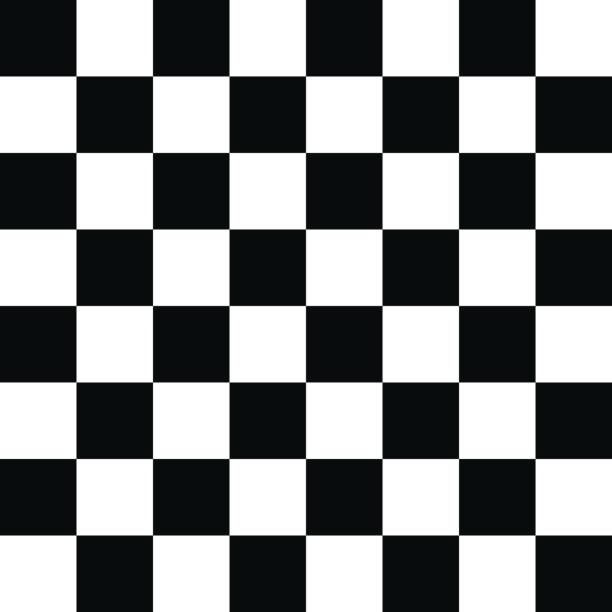

[chessboard3.jpg] → Black: 33, White: 31


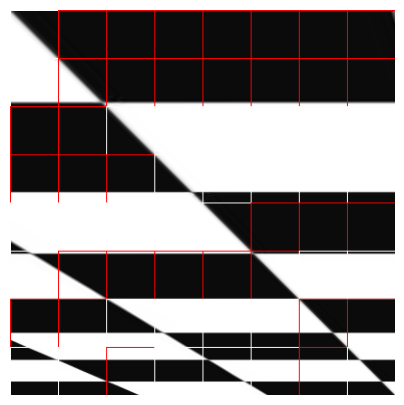

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload images
uploaded = files.upload()
images = [cv2.imread(path) for path in uploaded]
for img in images:
    cv2_imshow(img)

# Constants
PATTERN_SIZE = (7, 7)   # 7×7 inner corners → 8×8 squares
THRESH = 127

# 1) Detect corners & warp to top‑down
def detect_and_warp(img, pattern_size=PATTERN_SIZE):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Try the robust SB detector
    sb_flags = (cv2.CALIB_CB_NORMALIZE_IMAGE
                | cv2.CALIB_CB_ADAPTIVE_THRESH
                | cv2.CALIB_CB_EXHAUSTIVE
                | cv2.CALIB_CB_ACCURACY
                | cv2.CALIB_CB_LARGER)
    found, corners = cv2.findChessboardCornersSB(gray, pattern_size, sb_flags)

    # Fallback to classic if SB fails
    if not found:
        classic_flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
        found, corners = cv2.findChessboardCorners(gray, pattern_size, classic_flags)

    if not found:
        # No corner grid found → return original
        return img

    # Reshape & sort corners (row‑major)
    pts = corners.reshape(-1, 2)
    idx = np.lexsort((pts[:,0], pts[:,1]))
    pts = pts[idx]

    # Estimate one cell width & height
    cell_w = np.linalg.norm(pts[1] - pts[0])
    cell_h = np.linalg.norm(pts[pattern_size[0]] - pts[0])

    # Compute the 4 board corners
    tl = pts[0] + np.array([-cell_w/2, -cell_h/2])
    tr = pts[pattern_size[0]-1] + np.array([ cell_w/2, -cell_h/2])
    bl = pts[-pattern_size[0]] + np.array([-cell_w/2,  cell_h/2])
    br = pts[-1]              + np.array([ cell_w/2,  cell_h/2])

    src = np.vstack([tl, tr, br, bl]).astype(np.float32)
    w_dst = int(pattern_size[0] * cell_w)
    h_dst = int(pattern_size[1] * cell_h)
    dst = np.array([[0,0], [w_dst-1,0], [w_dst-1,h_dst-1], [0,h_dst-1]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (w_dst, h_dst))
    return warped

# 2) Subdivide & count
def count_squares(img, grid=(8,8), threshold=THRESH):
    rows, cols = grid
    h, w = img.shape[:2]
    cell_h, cell_w = h/rows, w/cols
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    out = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    black = white = 0
    for i in range(rows):
        for j in range(cols):
            y1, y2 = int(i*cell_h), int((i+1)*cell_h)
            x1, x2 = int(j*cell_w), int((j+1)*cell_w)
            roi = gray[y1:y2, x1:x2]
            if roi.size == 0: continue
            mean = float(roi.mean())
            if mean < threshold:
                black += 1
                color = (0,0,255)
            else:
                white += 1
                color = (255,255,255)
            cv2.rectangle(out, (x1,y1), (x2,y2), color, 1)
    return out, black, white

# 3) Run on each image
for fn, _ in uploaded.items():
    img = cv2.imread(fn)
    warped = detect_and_warp(img)
    # normalize display size
    warped = cv2.resize(warped, (400,400))
    annotated, b, w = count_squares(warped)
    print(f"[{fn}] → Black: {b}, White: {w}")
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
